# Project: ML - Deatailed Multivariate Liner Regression, Random Forest and GradientBoosting (Predict Bike Rentals)

<br>

## Problem:
- Predict how many people rented bikes per hour from data on: time of day, season, wind, temperature, workday, etc)
- Regression with multivariate LinearRegression, RandomForestRegressor and GradientBoostingRegressor
- Full analysis of LinearRegression output including Pvalues

<br>

## Tools:
- Feature Engineering: .corr(), heatmap & RFECV
- Models: multivariate LinearRegression, RandomForestRegressor and GradientBoostingRegressor
- Model validation and hyperparameter search: GriSearchCV + K-fold validation and predictions
- Error Metrics: R^2, explained variance, RMSE and MAE

<br>

### load defaults

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import re
import requests 

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from matplotlib import rcParams
import matplotlib.dates as mdates
from datetime import datetime
from IPython.display import display, Math

from functions import *

#plt.style.use('seaborn')
plt.rcParams.update({'axes.titlepad': 20, 'font.size': 12, 'axes.titlesize':20})
plt.rcParams.update({'xtick.direction': 'in', 'ytick.direction': 'in'})
plt.rcParams.update({'xtick.top': 'on', 'ytick.right': 'on'})

colors = [(0/255,107/255,164/255), (255/255, 128/255, 14/255), 'red', 'green', '#9E80BA', '#8EDB8E', '#58517A']
Ncolors = 10
color_map = plt.cm.Blues_r(np.linspace(0.2, 0.5, Ncolors))
#color_map = plt.cm.tab20c_r(np.linspace(0.2, 0.5, Ncolors))


#specific to this project
import scipy.stats as stats
import statsmodels.api as sm
import myML_functions as myML_functions

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.model_selection import cross_val_score, KFold, cross_val_predict, GridSearchCV

print("Defaults Loaded")

Defaults Loaded


<br>

## Dataset: Bike Rentals, predict number of people renting a bike in a given hour

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32


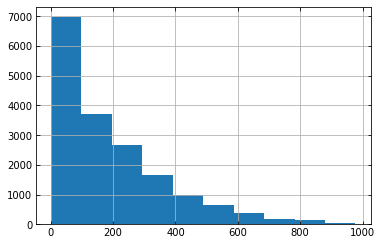

In [11]:
bike_rentals = pd.read_csv('./data/bike_rental_hour.csv')
display(bike_rentals[:3])

bike_rentals['cnt'].hist()
plt.show()

create new label for the hours in which bikes were rented

In [12]:
def assign_label(hour):    
    if((hour>=6) & (hour<12)):
        return 1
    elif((hour>=12) & (hour<18)):
        return 2
    elif((hour>=18) & (hour<24)):
        return 3
    elif((hour>=0) & (hour<6)):
        return 4
    
bike_rentals['time_label'] = bike_rentals['hr'].apply(lambda x: assign_label(x))
#print(bike_rentals[0:19])

**drop leaky columns**

In [13]:
bike_rentals.drop(['instant', 'casual', 'dteday', 'registered'], axis=1, inplace=True)
df_clean = bike_rentals
target = 'cnt'
target_df = df_clean[target]

<br>

## 2 - Linear Regression model

We will start our analysis by fitting a Linear Regression model and looking at a number of statsitics available for this type of model

### 2.1 - Fit model and cross_val_predict

In [5]:
import time
start = time.time()
     
columns = df_clean.columns.drop(['cnt'])

kf = KFold(10, shuffle=True, random_state=1)

model = LinearRegression(fit_intercept=True, normalize=False) 
predictions = cross_val_predict(model, df_clean[columns], df_clean['cnt'], cv=kf, n_jobs=-1)

X = df_clean[columns]
target_df = df_clean[target]
model.fit(X, target_df)

print(f"Time taken to build models: {time.time() - start:0.2f}s")

Time taken to build models: 2.00s



### 2.2 - Plot Predictions vs target

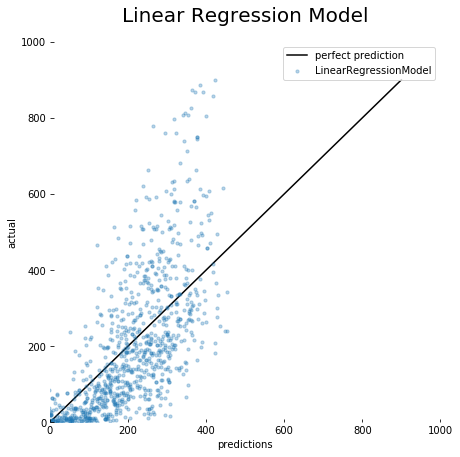

In [6]:
fig, ax = plt.subplots(figsize=(7,7))
lim = [0,1000]
ax.set_xlim(lim), ax.set_ylim(lim)

# Plot the perfect prediction line
xmin, xmax = plt.xlim()
bin = int((xmax-xmin)/10)
ax.plot(np.arange(xmin, xmax, bin), np.arange(xmin, xmax, bin), c='k', label='perfect prediction', zorder=-1)

# Create a scatter plot with train and test actual vs predictions

rand_index = np.random.randint(0, high=len(predictions), size=1000).tolist()
ax.scatter(predictions[rand_index], target_df[rand_index], alpha=0.3, label='LinearRegressionModel', 
           marker='o', s=10)

for key, spine in ax.spines.items():
    spine.set_visible(False)
ax.tick_params(top=False, right=False)

#ax.yaxis.set_major_locator(MultipleLocator(200000))    
#ax.xaxis.set_major_locator(MultipleLocator(200000))    

plt.xlabel('predictions')
plt.ylabel('actual')
plt.title('Linear Regression Model')
plt.legend()
plt.show()

the linear regression model is particularly bad for high counts, never predicting more than ~450 when true values reach >800

### 2.3 - Calculate Error Metrics & Check significance of individual coefficients

In [7]:
myML_functions.regression_report(X, target_df, predictions, model)

-----------------------------------------------------------------
                Summary of Regression model stats                
RMSE:              132.30         RMSE (in % of y_mean):   69.83%
MAE:                99.43         MAE (in % of y_mean):    52.48%
R2:                 0.468 
R2_score:           0.468
Explained Var:      0.468
Features        coef   std err    t    P>|t| 
-----------------------------------------------------------------
   constant  103.9845   7.058  14.733  0.000
     season   20.2764   1.697  11.948  0.000
         yr   82.6244   2.020  40.906  0.000
       mnth   -0.3281   0.529  -0.620  0.535
         hr    6.6052   0.155  42.536  0.000
    holiday  -21.9687   6.246  -3.517  0.000
    weekday    2.0670   0.505   4.097  0.000
 workingday    4.2739   2.235   1.912  0.056
 weathersit  -11.4426   1.784  -6.414  0.000
       temp   84.6942  34.484   2.456  0.014
      atemp  212.2490  38.741   5.479  0.000
        hum -161.9035   6.467 -25.036  0.000
  win

**similar metrics using statsmodels**

In [9]:
newX = sm.add_constant(X) 
linear = sm.OLS(target_df, newX)
linearfit = linear.fit()
print(linearfit.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.469
Model:                            OLS   Adj. R-squared:                  0.468
Method:                 Least Squares   F-statistic:                     1179.
Date:                Sat, 27 Apr 2019   Prob (F-statistic):               0.00
Time:                        14:27:28   Log-Likelihood:            -1.0954e+05
No. Observations:               17379   AIC:                         2.191e+05
Df Residuals:                   17365   BIC:                         2.192e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        103.9845      7.052     14.745      0.0

/home/brunohe/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


- **t statistic**: is the coefficient divided by its standard deviation (precision of the regression coefficient measurement). This is then compared with values in the Student's t distribution to determine the P value. The Student's t distribution describes how the mean of a sample with a certain number of observations is expected to behave.

- **p-value**: If 95% of the t distribution is closer to the mean than the t-value on the coefficient, then P-value = 5%. The P value is the probability of seeing a t value equally large in a collection of random data in which the variable had no effect (95% probability of variable having some effect, assuming model is specified correctly).

- **P-value for the entire correlation**: Because independent variables may be correlated, a condition known as multicollinearity, the coefficients on individual variables may be insignificant when the regression as a whole is significant. Intuitively, this is because highly correlated independent variables are explaining the same part of the variation in the dependent variable, so their explanatory power and the significance of their coefficients is "divided up" between them.

- **95% confidence interval**: If a value of 0 for the coefficient is not in the confidence interval, there is a 95% probability of the coefficeint being non zero: P value <= .05.

- the size of the P-value for a coefficient says nothing about the size of the effect that variable is having on a dependent variable - it is possible to have a highly significant result (very small P-value) for a miniscule effect.

- **Coefficients**: the size of coefficients for each independent variable gives the size of the effect that the variable is having on the dependent variable, and the sign gives the direction of the effect. The coefficient represents how much the dependent variable is expected to increase when that independent variable increases by one, holding all the other independent variables constant. 

- **R-Squared and overall significance of the regression**: fraction of the variation in the dependent variable that is accounted for by the independent variables (in univariate regression is the same as the square of the correlation between the dependent and independent variables). The R-squared is only critical when the main concern is to make accurate predictions. 

<br>

### 2.4 - Remove coefficients with high pvalues

In [10]:
import time
start = time.time()
     
columns = df_clean.columns.drop(['cnt', 'mnth', 'workingday', 'windspeed', 'temp'])

kf = KFold(10, shuffle=True, random_state=1)

model = LinearRegression(fit_intercept=True, normalize=False) 
predictions = cross_val_predict(model, df_clean[columns], df_clean['cnt'], cv=kf, n_jobs=-1)

X = df_clean[columns]
target_df = df_clean['cnt']
model.fit(X, target_df)

myML_functions.regression_report(X, target_df, predictions, model)
print(f"Time taken to build models: {time.time() - start:0.2f}s")

-----------------------------------------------------------------
                Summary of Regression model stats                
RMSE:              132.33         RMSE (in % of y_mean):   69.85%
MAE:                99.32         MAE (in % of y_mean):    52.42%
R2:                 0.468 
R2_score:           0.468
Explained Var:      0.468
Features        coef   std err    t    P>|t| 
-----------------------------------------------------------------
   constant  110.5502  6.161  17.945  0.0
     season   19.2449  0.974  19.750  0.0
         yr   82.4797  2.019  40.857  0.0
         hr    6.6133  0.155  42.655  0.0
    holiday  -24.7211  6.043  -4.091  0.0
    weekday    2.1189  0.504   4.205  0.0
 weathersit  -10.4547  1.762  -5.934  0.0
      atemp  306.4619  6.281  48.791  0.0
        hum -167.9148  6.179 -27.176  0.0
 time_label  -47.4545  0.926 -51.249  0.0
Time taken to build models: 1.68s


no improvement on metrics

<br>

## 3 - Feature Selection

### 3.1 Feature Selection with .corr() & Heatmap

['cnt', 'temp', 'atemp', 'hr', 'time_label', 'hum', 'yr']
cnt           1.000000
temp          0.404772
atemp         0.400929
hr            0.394071
time_label    0.378318
hum           0.322911
yr            0.250495
Name: cnt, dtype: float64


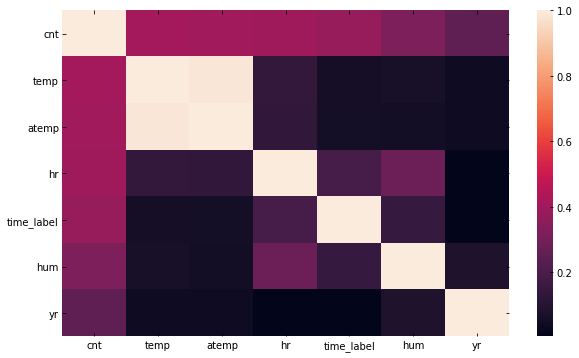

In [11]:
num_cols = df_clean.select_dtypes(include=['int64','float64']).columns  
corrmat = df_clean[num_cols].corr()
sorted_corrs = corrmat[target].abs().sort_values(ascending=False)
strong_corrs = sorted_corrs[sorted_corrs>0.25].index.tolist()
print(strong_corrs)
print(sorted_corrs[sorted_corrs>0.25])

plt.figure(figsize=(10,6))
sns.heatmap(df_clean[strong_corrs].corr().abs())
plt.show()

In [12]:
selected_features_manual = ['temp', 'atemp', 'hr', 'time_label', 'hum', 'yr']

<br>

### 3.2 - Feature selection with RFECV

In [15]:
from importlib import reload
reload(myML_functions)

model=LinearRegression()
optimized_columns_LR = myML_functions.select_features_RFECV(df_clean, target, model)

model = RandomForestRegressor(n_estimators=50, random_state=1, min_samples_leaf=2, n_jobs=-1)    
optimized_columns_RFR = myML_functions.select_features_RFECV(df_clean, target, model)

model = GradientBoostingRegressor(learning_rate=0.01, n_estimators=50,subsample=0.6,random_state=42)
optimized_columns_GBR = myML_functions.select_features_RFECV(df_clean, target, model)

Best Columns, LinearRegression model: ['season', 'yr', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'time_label']

----------------------------------------------------

Best Columns, RandomForestRegressor model: ['season', 'yr', 'mnth', 'hr', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum']

----------------------------------------------------

Best Columns, GradientBoostingRegressor model: ['yr', 'hr', 'temp']

----------------------------------------------------



<br>

## 4 - Model Selection with GridSearchCV

In [17]:
import time
                  
models_to_fit = {'LinearRegression': ['LinearRegression', optimized_columns_LR],                    
                 'RandomForestRegressor_1': ['RandomForestRegressor', optimized_columns_RFR],
                 'RandomForestRegressor_2': ['RandomForestRegressor', selected_features_manual],
                 'GradientBoostingRegressor': ['GradientBoostingRegressor', optimized_columns_GBR]}

#print(int(len(df_clean)/10.))
model_dicts = myML_functions.select_model_GridSearchCV(df_clean[:int(len(df_clean))],target,models_to_fit)

print("model selection finished")

LinearRegression
----------------
Explained Variance: 0.271
R2: 0.249
RMSE: 134.948
Best Parameters: {'fit_intercept': True, 'normalize': False}
Best Score: 0.249

Time elapsed: 0.01 mins


RandomForestRegressor_1
-----------------------
Explained Variance: 0.815
R2: 0.783
RMSE: 65.744
Best Parameters: {'criterion': 'mse', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 20}
Best Score: 0.783

Time elapsed: 1393.07 mins


RandomForestRegressor_2
-----------------------
Explained Variance: 0.646
R2: 0.579
RMSE: 96.632
Best Parameters: {'criterion': 'mae', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 20}
Best Score: 0.579

Time elapsed: 960.85 mins


GradientBoostingRegressor
-------------------------
Explained Variance: 0.641
R2: 0.602
RMSE: 97.222
Best Parameters: {'learning_rate': 0.1, 'max_features': 'auto', 'n_estimators': 100, 'random_state': 1, 'subsample': 0.5}
Best S

<br>

## 5 - Cross_Val Predictions for best models (RandomForest & GradientBoosting)

In [6]:
optimized_columns_RFR = ['season', 'yr', 'mnth', 'hr', 'weekday', 'workingday', 'weathersit', 'temp', 'atemp', 'hum']
optimized_columns_GBR = ['yr', 'hr', 'temp']

In [7]:
import time
start = time.time()
     
kf = KFold(10, shuffle=True, random_state=1)

best_model = {'criterion': 'mae', 'max_depth': 10, 'max_features': 'auto', 'min_samples_leaf': 1, 
              'min_samples_split': 2, 'n_estimators': 20, 'n_jobs': -1}
model = RandomForestRegressor()
model.set_params(**best_model)  
pred_1 = cross_val_predict(model, df_clean[optimized_columns_RFR], df_clean[target], cv=kf, n_jobs=-1)

best_model = {'learning_rate': 0.1, 'max_features': 'auto', 'n_estimators': 100, 'random_state': 1,
              'subsample': 0.5}
model = GradientBoostingRegressor()
model.set_params(**best_model)  
pred_2 = cross_val_predict(model, df_clean[optimized_columns_GBR], df_clean[target], cv=kf, n_jobs=-1)

print(f"Time taken to build models: {(time.time() - start)/60.:0.2f} mins")

Time taken to build models: 6.49 mins


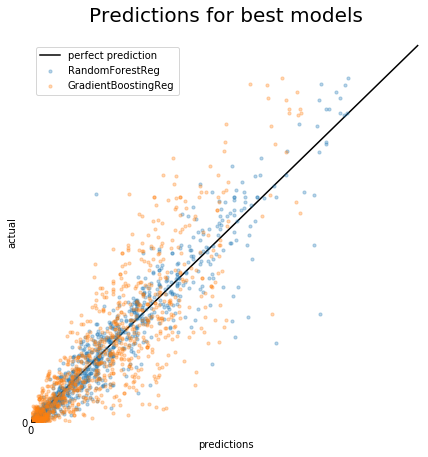

In [14]:
fig, ax = plt.subplots(figsize=(7,7))
lim = [0,1000]
ax.set_xlim(lim), ax.set_ylim(lim)

# Plot the perfect prediction line
xmin, xmax = ax.get_xlim()
bin = int((xmax-xmin)/100)
ax.plot(np.arange(xmin, xmax, bin), np.arange(xmin, xmax, bin), c='k', label='perfect prediction', zorder=-1)

# Create a scatter plot with train and test actual vs predictions
rand_index = np.random.randint(0, high=len(pred_1), size=1000).tolist()
ax.scatter(pred_1[rand_index], target_df[rand_index], alpha=0.3, label='RandomForestReg', marker='o', s=10)
ax.scatter(pred_2[rand_index], target_df[rand_index], alpha=0.3, label='GradientBoostingReg', marker='o',s=10)

for key, spine in ax.spines.items():
    spine.set_visible(False)
ax.tick_params(top=False, right=False)

ax.yaxis.set_major_locator(MultipleLocator(200000))    
ax.xaxis.set_major_locator(MultipleLocator(200000))    

plt.xlabel('predictions')
plt.ylabel('actual')
plt.title('Predictions for best models')
plt.legend()
plt.show()